<a href="https://colab.research.google.com/github/sush0677/Assigment/blob/main/CVAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Thresholding***

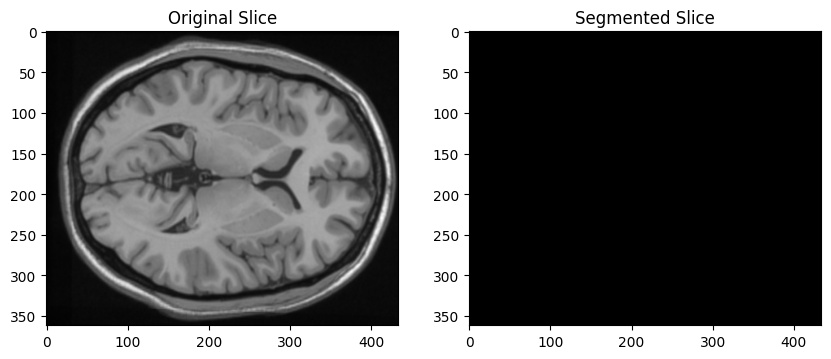

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Load MRI data
data = loadmat('Brain.mat')
T1 = data['T1']  # MRI images
label = data['label']  # Pre-segmented images

# Function to apply thresholding
def thresholding(image, threshold):
    # Apply threshold
    segmented = np.where(image > threshold, 1, 0)
    return segmented

# Choose a slice to work with
slice_index = 0  # Example: first slice
slice_image = T1[:, :, slice_index]

# Visual inspection to choose a threshold
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(slice_image, cmap='gray')
plt.title('Original Slice')

# Apply thresholding - you may need to adjust this value
threshold_value = 100  # Example threshold value
segmented_slice = thresholding(slice_image, threshold_value)

plt.subplot(1, 2, 2)
plt.imshow(segmented_slice, cmap='gray')
plt.title('Segmented Slice')
plt.show()


# ***Otsu's Method and K-mean***

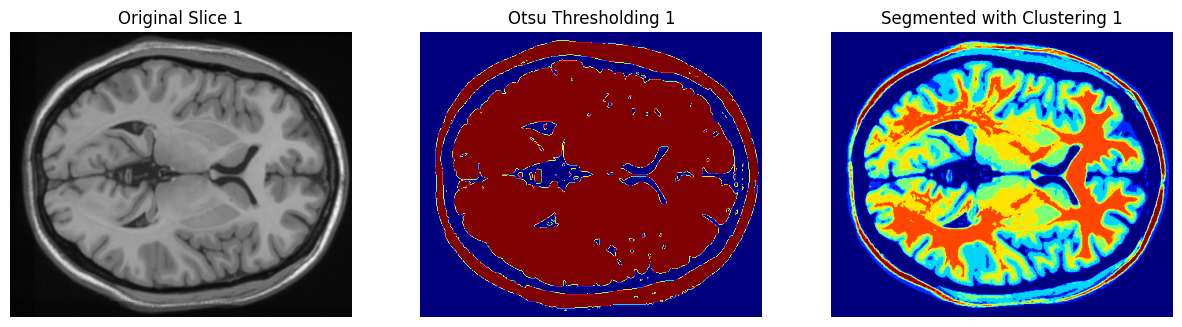

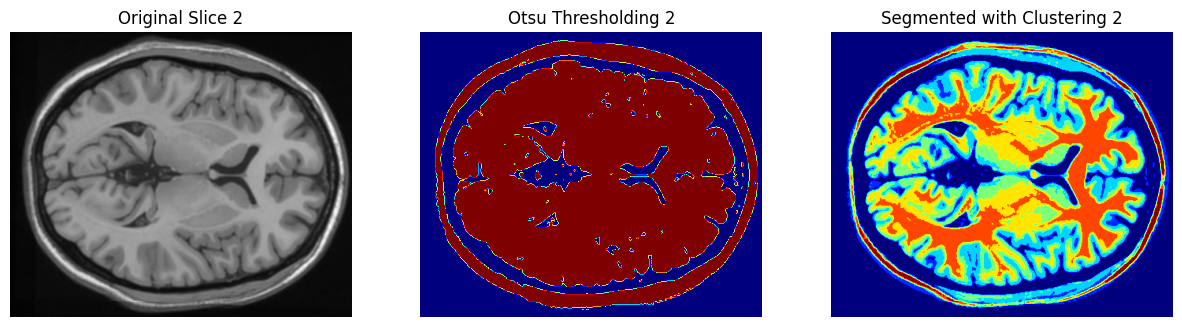

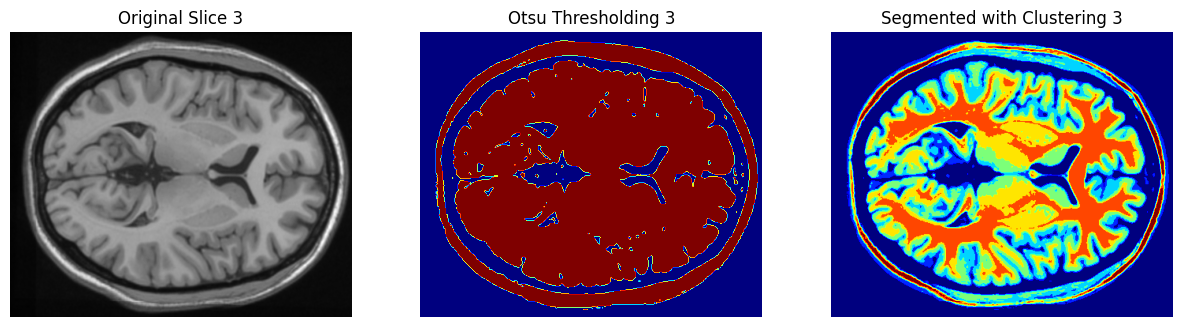

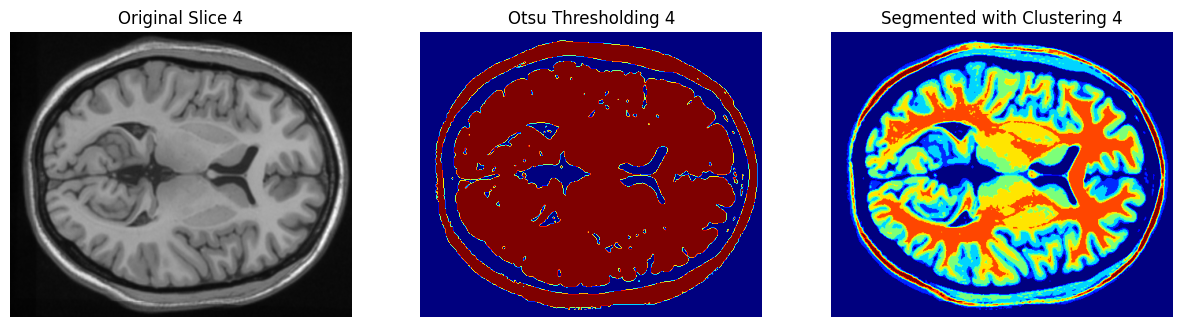

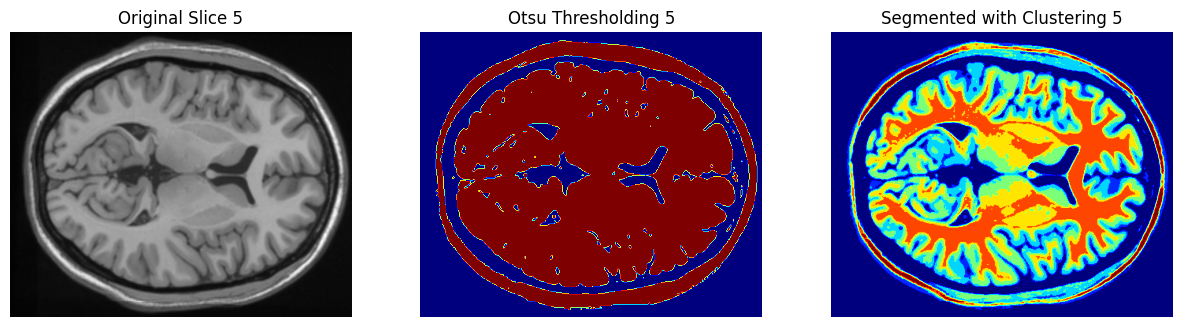

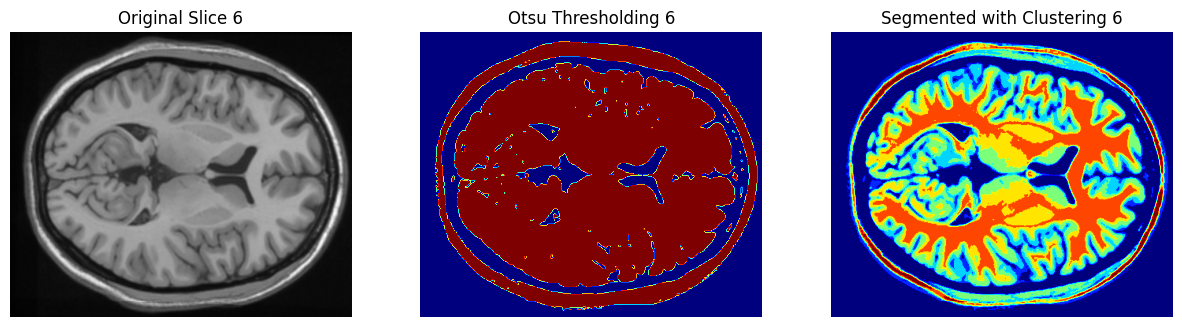

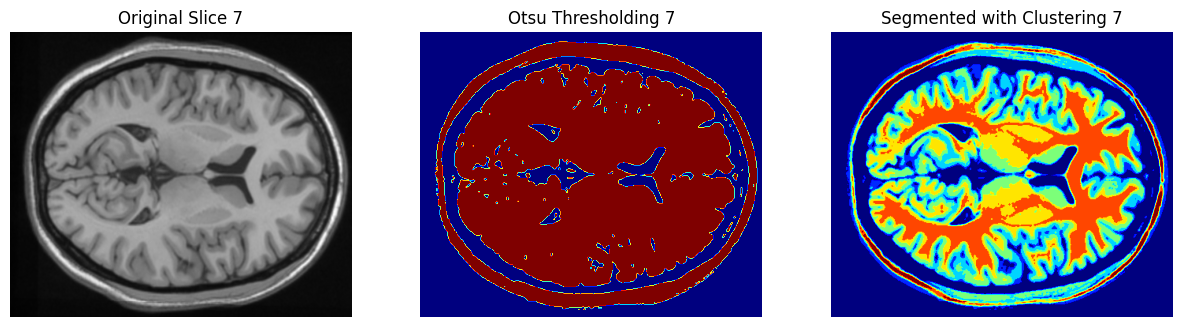

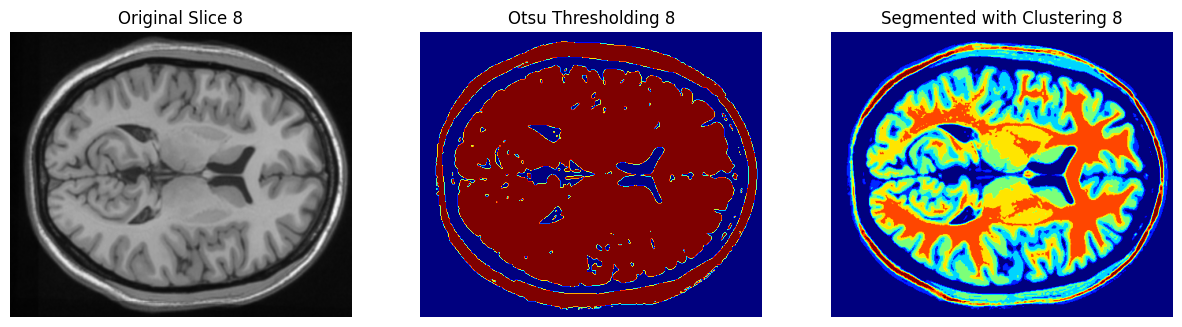

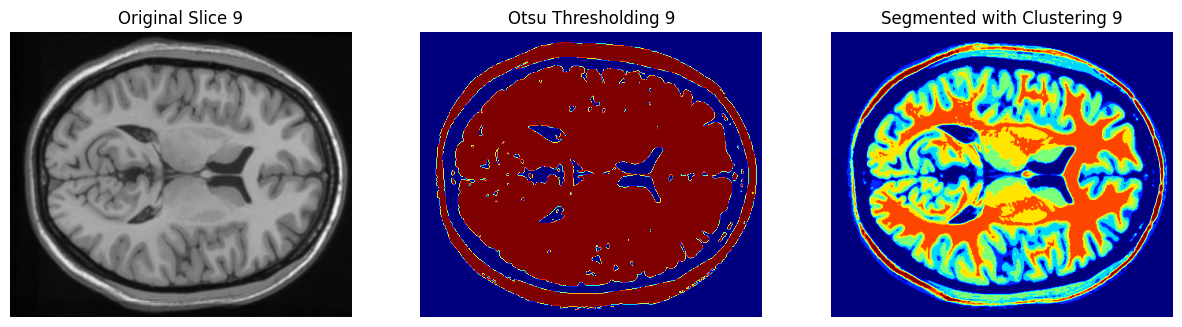

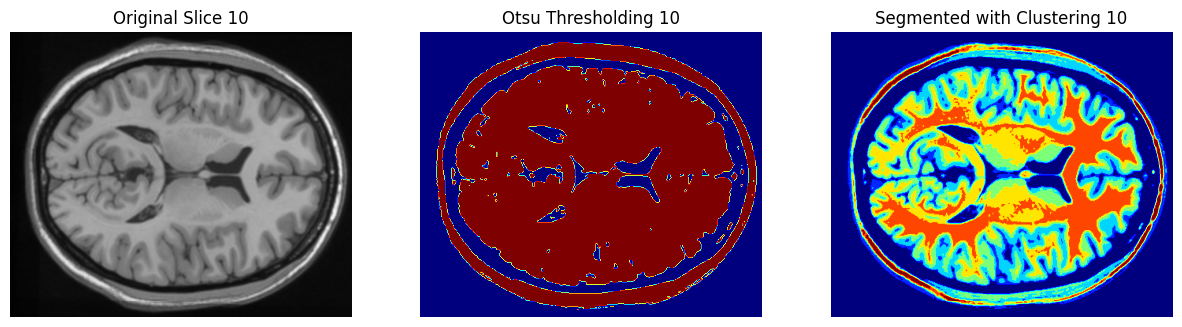

In [6]:
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Load the .mat file
mat = loadmat('Brain.mat')  # Replace with the correct path to your Brain.mat file
T1 = mat['T1'].astype(np.float32)  # Assuming 'T1' is the key for MRI slices
num_slices = T1.shape[2]

# Define a function to map K-means labels to tissue types
def map_labels_to_tissue_types(kmeans, centroids_order):
    sorted_idx = np.argsort(kmeans.cluster_centers_.flatten())
    mapping = dict(zip(sorted_idx, centroids_order))
    mapped_labels = np.vectorize(mapping.get)(kmeans.labels_)
    return mapped_labels

# Define the order of centroids based on expected tissue brightness
centroids_order = [0, 1, 2, 3, 4, 5]  # Air, Skin, Skull, CSF, Gray Matter, White Matter

for i in range(num_slices):
    slice = T1[:, :, i]
    slice_normalized = (slice - np.min(slice)) / (np.max(slice) - np.min(slice))

    thresh = threshold_otsu(slice_normalized)
    binary_mask = slice_normalized > thresh

    foreground_pixels = slice_normalized[binary_mask].reshape(-1, 1)

    kmeans = KMeans(n_clusters=6, n_init=10, random_state=42)
    kmeans.fit(foreground_pixels)

    # Map the K-means cluster labels to tissue types
    mapped_labels = map_labels_to_tissue_types(kmeans, centroids_order)

    segmented_slice = np.zeros_like(slice_normalized)
    segmented_slice[binary_mask] = mapped_labels + 1  # Offset by 1 to differentiate from background

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(slice_normalized, cmap='gray')
    plt.title(f'Original Slice {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(binary_mask, cmap='jet')
    plt.title(f'Otsu Thresholding {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(segmented_slice, cmap='jet')
    plt.title(f'Segmented with Clustering {i+1}')
    plt.axis('off')

    plt.show()


# ***K-means and Watershed***

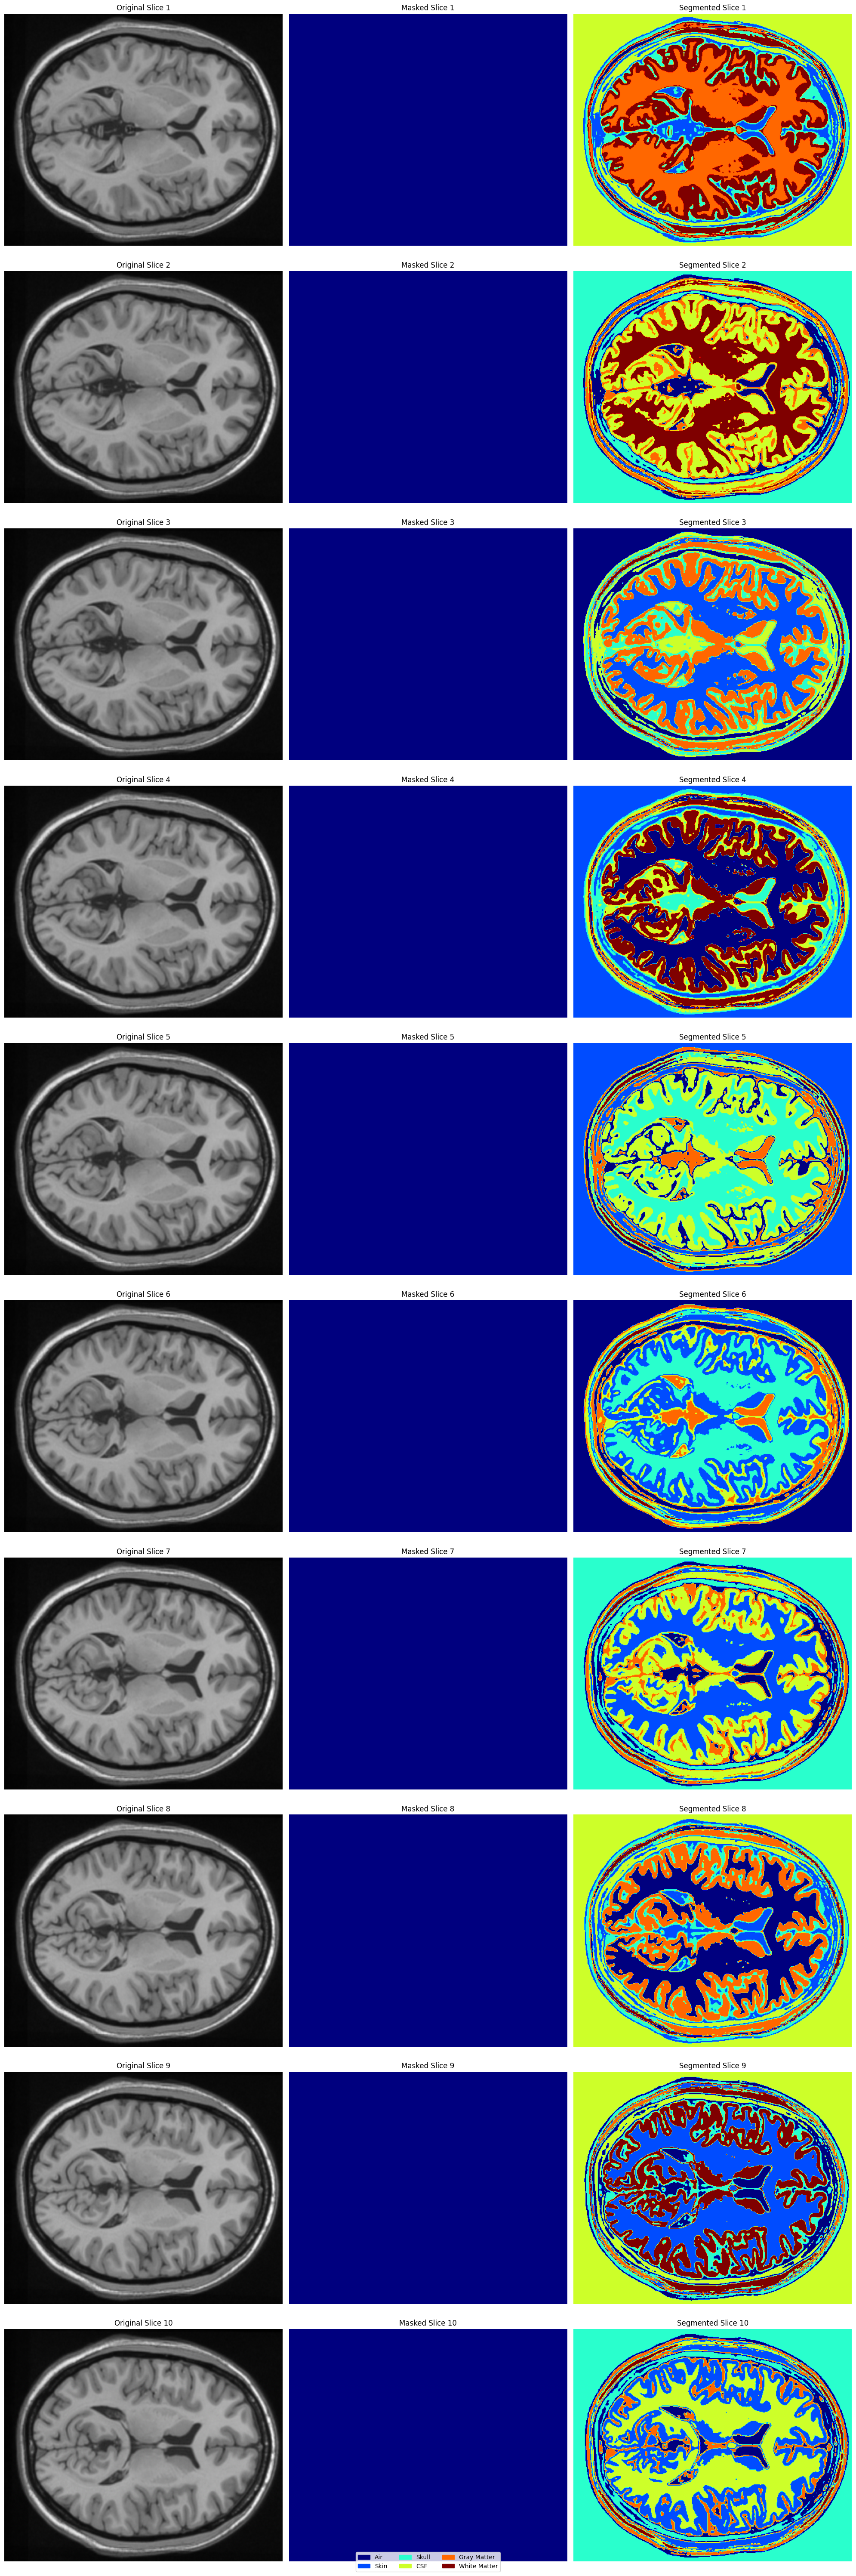

In [9]:
from sklearn.cluster import KMeans
from skimage.morphology import disk, dilation
from skimage.segmentation import watershed
from skimage.filters import rank, sobel
from scipy import ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.color import label2rgb
from scipy.io import loadmat
from skimage.filters import threshold_otsu


# Load and normalize the data
mat = loadmat('Brain.mat')  # Update with the correct path
T1 = mat['T1'].astype(np.float32)
T1_normalized = (T1 - np.min(T1)) / (np.max(T1) - np.min(T1))

n_clusters = 6  # Adjust based on the number of tissue types you're identifying

fig, axes = plt.subplots(10, 3, figsize=(20, 60))  # Setup figure

for i in range(T1_normalized.shape[2]):  # Loop through each slice
    slice_img = T1_normalized[:, :, i]

    # Watershed for masking
    gradient = sobel(slice_img)
    markers = ndi.label(dilation(slice_img > threshold_otsu(slice_img), disk(5)))[0]
    mask = watershed(gradient, markers) > 0

    # K-means for segmentation within the masked region
    foreground_pixels = slice_img[mask].reshape(-1, 1)
    if foreground_pixels.size > 0:
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(foreground_pixels)
        segmented_slice = np.zeros_like(slice_img)
        segmented_slice[mask] = kmeans.labels_ + 1  # Mapping labels to segmented regions

    # Visualization
    ax_original = axes[i, 0]
    ax_original.imshow(slice_img, cmap='gray')
    ax_original.axis('off')
    ax_original.set_title(f'Original Slice {i+1}')

    ax_masked = axes[i, 1]
    ax_masked.imshow(mask, cmap='jet')
    ax_masked.axis('off')
    ax_masked.set_title(f'Masked Slice {i+1}')

    ax_segmented = axes[i, 2]
    ax_segmented.imshow(segmented_slice, cmap='jet')  # Using 'jet' for segmented visualization
    ax_segmented.axis('off')
    ax_segmented.set_title(f'Segmented Slice {i+1}')

# Legend for tissue types
tissue_types = ['Air', 'Skin', 'Skull', 'CSF', 'Gray Matter', 'White Matter']
patches = [mpatches.Patch(color=plt.cm.jet(i / (n_clusters - 1)), label=tissue_types[i] if i < len(tissue_types) else 'Other') for i in range(len(tissue_types))]
fig.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=3)

plt.tight_layout()
plt.show()